## Import Libraries and Data

In [1]:
import PipettingMassBalance as pmb
import pandas as pd
%matplotlib notebook

speciesList = pmb.PipettingSpecies.readCSV('SpeciesDictionary.csv')
instructions = pmb.PipettingInstructions.readCSV('DoE_csv/PhD_MasterDataset_OT_initial.csv', firstRow=30, lastRow=36)
targetVolume = 10
sampleList = pmb.PipettingSample.createSamples(instructions,targetVol=targetVolume)
maxVolume = 1
for sample in sampleList:
    sample.getTotalDensity(speciesDictionary=speciesList)
    sample.getVolFracSeries(speciesDictionary=speciesList)
steps = pmb.PipettingStep.createSteps(instructions=instructions,speciesDictionary=speciesList,sampleList=sampleList,maxVol=maxVolume)

massProfile = pmb.MassProfile('mass_data/MassProfile_141222_S31-36_run2.csv',t_baseline=25)

C:\Users\ACHI01\Dell_PycharmProjects\formulations-prep\PipettingMassBalance.py:84: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (specName,massFrac) in self.massFracSeries.iteritems():
C:\Users\ACHI01\Dell_PycharmProjects\formulations-prep\PipettingMassBalance.py:97: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (name,val) in self.volFracSeries.iteritems():
C:\Users\ACHI01\Dell_PycharmProjects\formulations-prep\PipettingMassBalance.py:84: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (specName,massFrac) in self.massFracSeries.iteritems():
C:\Users\ACHI01\Dell_PycharmProjects\formulations-prep\PipettingMassBalance.py:97: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (name,val) in self.volFracSeries.iteritems():
C:\Users\ACHI01\Dell_PycharmProjects\for

## Analyse water addition

In [2]:
(water_mass,t1)=massProfile.analyseWater(avg_window=10,bl_mult=3)
water=pmb.PipettingSpecies.getSpecies(speciesList, 'water')
water_volume_act=water.getVolume(water_mass)
water_volume_set=0
for sample in sampleList:
    water_volume = sample.waterVol
    water_volume_set = water_volume_set + water_volume
    sample.actualMass = water_volume/water.density
print("This equals a volume of " + str(round(water_volume_act,3)) + "m; expected was "\
      + str(round(water_volume_set,3)) + "mL; error is " + str(round(abs((water_volume_set-water_volume_act)/water_volume_set)*100,3)) + "%")

Water Transfer started at t=68s and ended at t=494s; mass=49.74204999999999g
This equals a volume of 49.842m; expected was 49.875mL; error is 0.067%


## Analyise surfactants

<IPython.core.display.Javascript object>


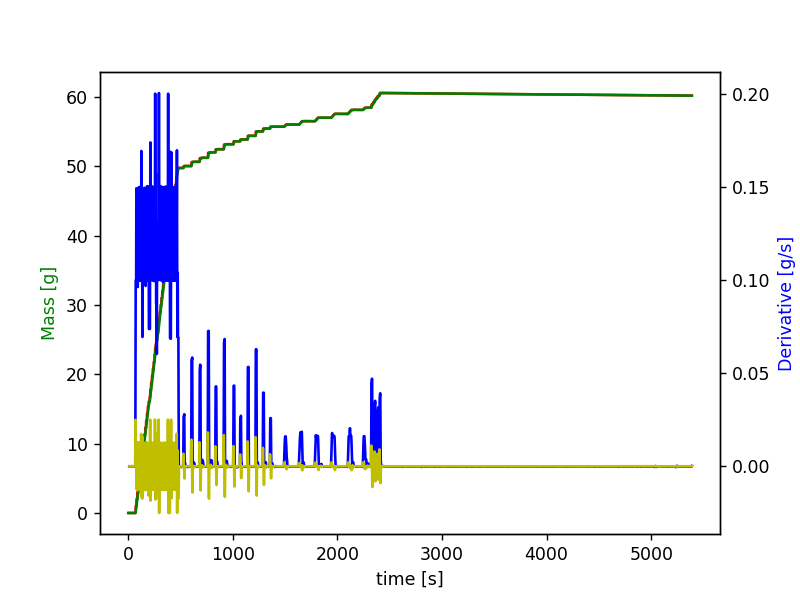

Addition of 0.285g Plantapon ACG 50 detected from 524s to 552s - expected volume = 0.281mL and actual volume = 0.251mL (resulting error is 10.812%)
Addition of 0.613g Plantapon ACG 50 detected from 600s to 640s - expected volume = 0.556mL and actual volume = 0.541mL (resulting error is 2.698%)
Addition of 0.59g Plantapon ACG 50 detected from 678s to 724s - expected volume = 0.485mL and actual volume = 0.521mL (resulting error is 7.218%)
Addition of 0.787g Plantapon ACG 50 detected from 758s to 806s - expected volume = 0.683mL and actual volume = 0.698mL (resulting error is 2.247%)
Addition of 0.452g Plantapon ACG 50 detected from 830s to 860s - expected volume = 0.397mL and actual volume = 0.398mL (resulting error is 0.378%)
Addition of 0.723g Plantapon ACG 50 detected from 910s to 952s - expected volume = 0.635mL and actual volume = 0.637mL (resulting error is 0.417%)
Addition of 0.432g Plantapon Amino SCG-L detected from 1002s to 1022s - expected volume = 0.441mL and actual volume = 

In [3]:
t2 = massProfile.analyseIngredients(avg_window=5, bl_mult=5, mergeSens=5, specType='surfactant',steps=steps,start_idx=t1,show=True)

## Analyse polyelectrolytes

<IPython.core.display.Javascript object>


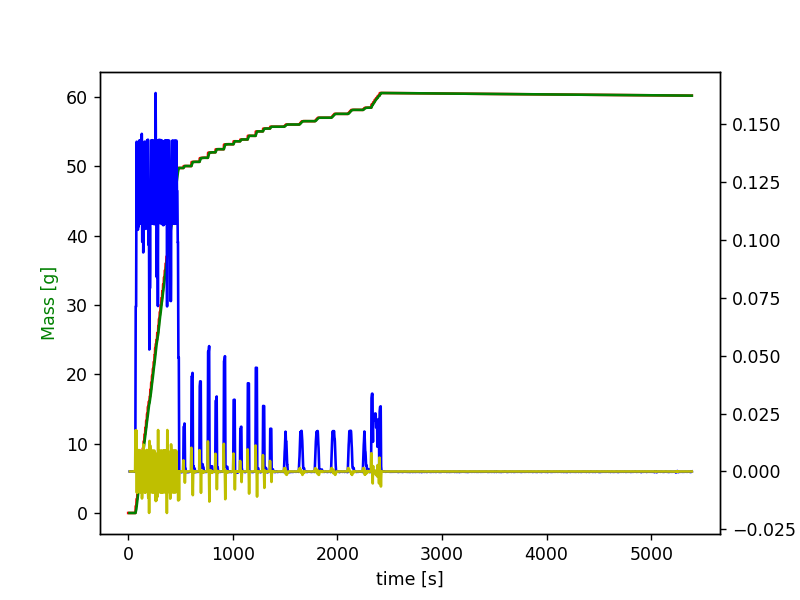

Addition of 0.319g Luviquat Excellence detected from 1486s to 1530s - expected volume = 0.324mL and actual volume = 0.287mL (resulting error is 11.448%)
Addition of 0.496g Luviquat Excellence detected from 1628s to 1690s - expected volume = 0.444mL and actual volume = 0.449mL (resulting error is 1.283%)
Addition of 0.504g Luviquat Excellence detected from 1780s to 1832s - expected volume = 0.453mL and actual volume = 0.456mL (resulting error is 0.743%)
Addition of 0.01g Luviquat Excellence detected from 1838s to 1858s - expected volume = 0.5mL and actual volume = 0.009mL (resulting error is 98.104%)
Addition of 0.558g Luviquat Excellence detected from 1936s to 1992s - expected volume = 0.525mL and actual volume = 0.504mL (resulting error is 3.879%)
Addition of 0.588g Luviquat Excellence detected from 2096s to 2164s - expected volume = 0.271mL and actual volume = 0.531mL (resulting error is 95.905%)


In [4]:
t3 = massProfile.analyseIngredients(avg_window=7, bl_mult=6, mergeSens=5, specType='polyelectrolyte',steps=steps,start_idx=t2,show=True)

## Analyse Thickeners

<IPython.core.display.Javascript object>


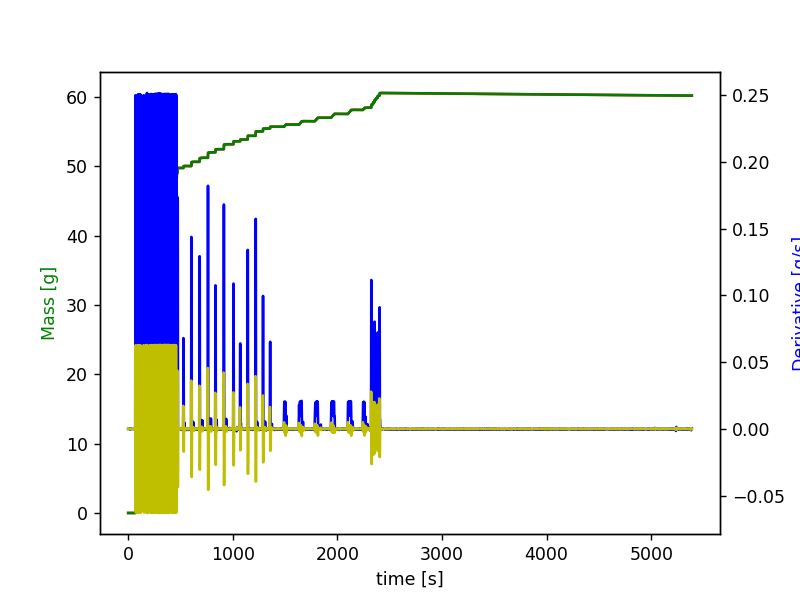

Addition of 0.282g Arlypon TT detected from 2240s to 2266s - expected volume = 0.561mL and actual volume = 0.293mL (resulting error is 47.778%)
Addition of 0.037g Arlypon TT detected from 2266s to 2276s - expected volume = 0.271mL and actual volume = 0.038mL (resulting error is 85.962%)
Addition of 0.481g Arlypon TT detected from 2286s to 2336s - expected volume = 0.344mL and actual volume = 0.502mL (resulting error is 45.758%)
Addition of 0.311g Arlypon TT detected from 2336s to 2348s - expected volume = 0.241mL and actual volume = 0.326mL (resulting error is 35.435%)
Addition of 0.349g Arlypon TT detected from 2350s to 2366s - expected volume = 0.313mL and actual volume = 0.364mL (resulting error is 16.333%)
Addition of 0.267g Arlypon TT detected from 2366s to 2380s - expected volume = 0.396mL and actual volume = 0.278mL (resulting error is 29.868%)


In [5]:
t4 = massProfile.analyseIngredients(avg_window=1, bl_mult=7, mergeSens=2, specType='thickener',steps=steps,start_idx=t3,show=True)

## Consolidate results and create output

In [8]:
for step in steps:
    step.addToSample()
actualMassFractions = pd.DataFrame(dtype='float64').reindex_like(instructions)
actualMassFractions[:]=0
for i in range(len(sampleList)):
    actualMassFractions['ID'].iloc[i] = sampleList[i].sampleId
    for entry in sampleList[i].addedMassSeries.iteritems():
        actualMassFractions[entry[0]].iloc[i] = entry[1]/sampleList[i].actualMass*100
actualMassFractions.to_csv('mass_data/AnalaysedComposition_141222_S25-30.csv', index=False)
actualMassFractions

C:\Users\ACHI01\AppData\Local\Temp\ipykernel_20040\4090109263.py:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for entry in sampleList[i].addedMassSeries.iteritems():


,ID,Texapon SB 3 KC,Plantapon ACG 50,Plantapon LC 7,Plantacare 818,Plantacare 2000,Dehyton MC,Dehyton PK 45,Dehyton ML,Dehyton AB 30,Plantapon Amino SCG-L,Plantapon Amino KG-L,Dehyquart A-CA,Luviquat Excellence,Dehyquart CC6,Dehyquart CC7 Benz,Salcare Super 7,Arlypon F,Arlypon TT
24,25.0,0.0,0.0,0.0,0.0,0.0,7.123445,0.0,0.0,0.0,0.0,0.0,3.517650,3.389704,0.0,0.0,0.0,0.0,3.464967
25,26.0,0.0,0.0,0.0,0.0,0.0,6.222311,0.0,0.0,0.0,0.0,0.0,6.737397,5.501922,0.0,0.0,0.0,0.0,3.755012
26,27.0,0.0,0.0,0.0,0.0,0.0,3.823615,0.0,0.0,0.0,0.0,0.0,6.482788,3.491342,0.0,0.0,0.0,0.0,4.364178
27,28.0,0.0,0.0,0.0,0.0,0.0,2.418270,0.0,0.0,0.0,0.0,0.0,5.665491,4.725502,0.0,0.0,0.0,0.0,5.675430
28,29.0,0.0,0.0,0.0,0.0,0.0,5.094847,0.0,0.0,0.0,0.0,0.0,2.235925,3.760412,0.0,0.0,0.0,0.0,2.595007
29,30.0,0.0,0.0,0.0,0.0,0.0,6.502055,0.0,0.0,0.0,0.0,0.0,6.899270,4.543853,0.0,0.0,0.0,0.0,4.338665
